# Titanic Logistic Regression (with Regularization and SGD)
##### 1. Import all necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

##### 2. Read csv and prepare data for Model 

In [2]:
#read csv
titanic_test = pd.read_csv("../input/titanic/train.csv", index_col='PassengerId')

In [3]:
titanic_test.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [4]:
titanic_test.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
#let's normalize the class
titanic_test['Pclass'] = round(titanic_test['Pclass'] / 3, 3)

In [7]:
#let's normalize the sex
titanic_test['Sex'] = (titanic_test['Sex'] == 'male').astype(int)

In [8]:
#let's normalize embarked 
# Southampton = S, Cherbourg = C, and Queenstown = Q
titanic_test["Embarked"].value_counts()
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 0.5
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 0
titanic_test["Embarked"].value_counts()

1.0    644
0.5    168
0.0     77
Name: Embarked, dtype: int64

In [9]:
#normalize the Fare
titanic_test["Fare"] = round(titanic_test["Fare"] / titanic_test["Fare"].mean(), 3)

In [10]:
#add new parametr rich and find normalized values
titanic_test["Rich"] = titanic_test["Fare"] * titanic_test["Pclass"]
titanic_test["Rich"] = round(titanic_test["Rich"] / titanic_test["Rich"].max(), 3)

In [11]:
#normalize the Age 
titanic_test["Age"] = titanic_test["Age"] / titanic_test["Age"].mean()
titanic_test["Age"] = round(titanic_test["Age"] / titanic_test["Age"].max(), 3)

In [12]:
#normalize the SibSp and Parch
titanic_test["SibSp"] = round(titanic_test["SibSp"] / titanic_test["SibSp"].max(), 3)
titanic_test["Parch"] = round(titanic_test["Parch"] / titanic_test["Parch"].max(), 3)

In [13]:
new_data = titanic_test[["Sex", "Age", "Embarked", "SibSp", "Parch", "Rich", "Survived"]]
new_data.corr()

,Sex,Age,SibSp,Parch,Rich,Survived
Sex,1.000000,0.093286,-0.114631,-0.245521,-0.186625,-0.543351
Age,0.093286,1.000000,-0.308303,-0.189177,-0.034823,-0.077231
SibSp,-0.114631,-0.308303,1.000000,0.414788,0.425767,-0.035322
Parch,-0.245521,-0.189177,0.414788,1.000000,0.391903,0.081704
Rich,-0.186625,-0.034823,0.425767,0.391903,1.000000,0.183695
Survived,-0.543351,-0.077231,-0.035322,0.081704,0.183695,1.000000


<AxesSubplot:>

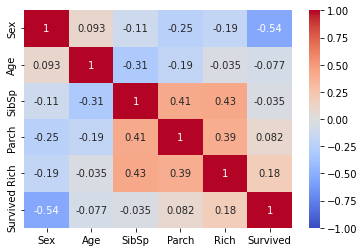

In [14]:
sns.heatmap(new_data.corr(), cmap='coolwarm', vmin = -1, vmax = 1, annot = True)

##### 3. Export of data 

In [15]:
new_data = titanic_test[["Sex", "Age", "Embarked", "SibSp", "Parch", "Rich", "Survived"]].dropna()
X = new_data[["Sex", "Age", "Embarked", "SibSp", "Parch", "Rich"]].to_numpy(float)
y = new_data["Survived"].to_numpy(float)

In [16]:
#let's separate data to X_train, y_train, X_test, y_test
def train_test_split(X, y, alpha = 0.5):
    n_1, k_1 = X.shape
    X_train = X[ :int(n_1 * alpha)]
    X_test = X[int(n_1 * alpha): ]
    y_train = y[ :int(n_1 * alpha)]
    y_test = y[int(n_1 * alpha): ]
    return X_train, X_test, y_train, y_test

#let's build train_test_split with shuffle 
def train_test_split_shuffle(X, y, alpha = 0.5):
    n_1, k_1 = X.shape
    ids = np.arange(n_1)
    np.random.shuffle(ids)
    len_of_part = int(n_1 * alpha)
    id_first = ids[: len_of_part]
    id_second = ids[len_of_part: ]
    X_train, X_test, y_train, y_test = X[id_first], X[id_second], y[id_first], y[id_second]
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = train_test_split_shuffle(X, y, 0.85)
print(X_train.shape[0])
print(X_test.shape[0])

605
107


##### 4. Setup of Model

In [18]:
#let's get to Logistic Regression
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def soft_sign(x, eps = 1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)

def logit(x, w): # the same as x @ w
    return np.dot(x, w) 

#metrics 
def mean_squared_error(y, y_pred): #not right metrics for that sort of linear function, but i still will be using it
    res = y - y_pred
    res = res ** 2
    return res.sum() / y.size

def mean_absolute_error():
    pass


def log_loss(y, p):
    p = np.clip(p, 1e-7, 1 - 1e-7)
    return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)) / len(y)

threshold = 0.5
all_tresholds = np.arange(0, 1.05, 0.05)

In [19]:
class LogisticRegression():
    def __init__ (self, fit_intercept = 1, coef_1 = 1, coef_2 = 1):
        self.fit_intercept = fit_intercept
        self.w = None
        self.loss = []
        self.coef_1 = coef_1
        self.coef_2 = coef_2 

    def fit(self, X, y, epochs = 10, lr = 0.1, batch_size = 100):
        n, k = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        for i in range(epochs): #rough but tough batch implementation
            for X_batch, y_batch in self.generate_batch(X, y, batch_size):

                y_pred = sigmoid(logit(X_batch, self.w))

                self.w -= self.calculate_gradient(X_batch, y_batch, y_pred) * lr
        

                self.loss.append(self.__loss(y_batch, y_pred))


    def calculate_gradient(self, X, y, y_pred):
        signw = np_soft_sign(self.w)

        grad_basic = logit(X.T, (y_pred - y))
        
        grad_l1 = signw * self.coef_1
        grad_l2 = 2 * self.coef_2 * self.w

        grad_l1[0] = grad_l2[0] = 0

        return grad_basic + grad_l1 + grad_l2
    
    def generate_batch(self, X, y, batch_size):
        n, k = X.shape
        X_train = np.concatenate((np.ones((n, 1)), X), axis = 1)
        id_s = np.arange(n)
        id = 0
        while ((id < n) and (id + batch_size < n)):
            yield  (X_train[id: id + batch_size],
                    y[id: id + batch_size])
            id += batch_size


    def predict(self, X):
        return self.predict_prob(X) >= threshold 

    def predict_prob(self, X):
        n, k = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(X @ self.w)

    def get_weights(self):
        return self.w.copy() 
    
    def get_loss(self):
        return self.loss.copy()

    def __loss(self, y, p):
        p = np.clip(p, 1e-7, 1 - 1e-7)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p)) / len(y)

##### 5. Finding of the most suitable hyperapms

In [20]:
#set up the grid of values (to find best ones)
coef1 = np.linspace(0, 5, 20)
coef2 = np.linspace(0, 5, 20)
epoechs = np.arange(1, 11)

In [21]:
#if you want you can uncomment this sections and find these optimum coefficients on you own
'''
optimum = [coef1[0], coef2[0]]
bedt_epoch = 0
res = 1

best_classifier = LogisticRegression() #put best classifier to this varible

for i in coef1:
    for j in coef2:
        for k in epoechs: 
            clf = LogisticRegression(coef_1 = i, coef_2 = j)
            clf.fit(X_train, y_train, epochs = k)
            prediction = clf.predict(X_test).astype(int)
            if mean_squared_error(prediction, y_test) < res:
                optimum[0] = i
                optimum[1] = j
                best_epoch = k
                res = mean_squared_error(prediction, y_test)
                best_classifier = clf
'''

optimum = [0.5263157894736842, 0.5263157894736842]
res = 0.1308411214953271
best_epoch = 6
best_classifier = LogisticRegression(coef_1 = optimum[0], coef_2 = optimum[1])
best_classifier.fit(X, y, epochs = 6)

In [22]:
'''
print(optimum)
print(res)
print(best_epoch)

'''
None

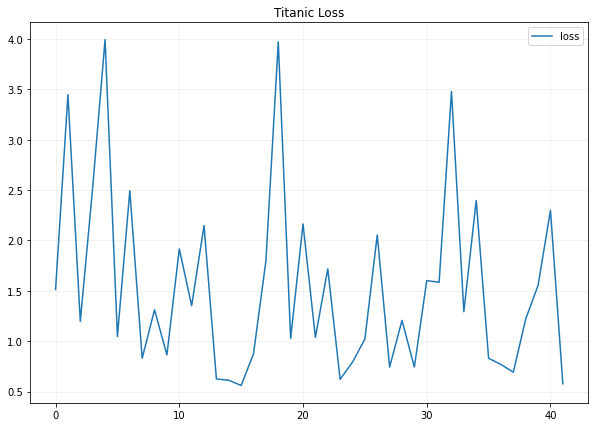

In [23]:
loss = best_classifier.get_loss()
plt.figure(figsize = (10, 7))
plt.plot(loss, label = 'loss')
plt.title("Titanic Loss")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

Let's estimate the accuracy of `best_classifier` via **FPR** and **TPR**

In [24]:
def roc_curve(y, y_pred, thresholds = all_tresholds):

    fpr = []
    tpr = []

    for threshold in thresholds:
        y_pred = np.where(y_pred >= threshold, 1, 0)

        fp = np.sum((y_pred == 1) & (y == 0))
        tp = np.sum((y_pred == 1) & (y== 1))

        fn = np.sum((y_pred == 0) & (y == 1))
        tn = np.sum((y_pred == 0) & (y == 0))
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    return fpr, tpr

In [25]:
prediction = best_classifier.predict_prob(X_test)
fpr = []
tpr = []
for i in all_tresholds:
    y_pred = np.where(prediction >= i, 1, 0)
    #print(y_pred)

    fp = np.sum((y_pred == 1) & (y_test == 0))
    tp = np.sum((y_pred == 1) & (y_test == 1))

    tn = np.sum((y_pred == 0) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))

    fpr.append(fp / (fp + tn))
    tpr.append(tp / (tp + fn))


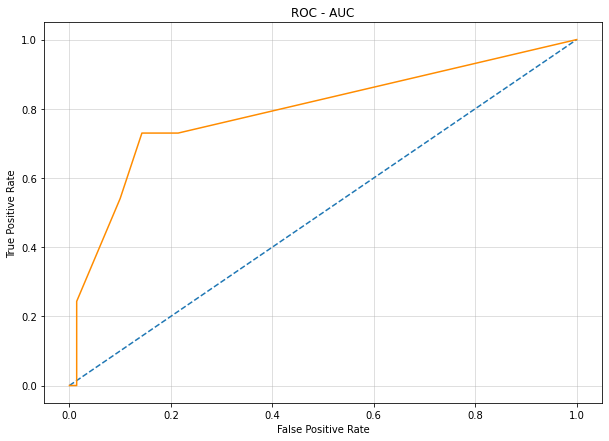

In [26]:
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr, tpr, color='darkorange',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha = 0.5)
plt.title("ROC - AUC")
plt.show()

##### 5. Finaly, repeat all first steps to test data and predict `submit_csv`

In [27]:
#read csv
titanic_test = pd.read_csv("../input/titanic/test.csv", index_col='PassengerId')

#all normalizations 
titanic_test['Pclass'] = round(titanic_test['Pclass'] / 3, 3)
titanic_test['Sex'] = (titanic_test['Sex'] == 'male').astype(int)
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 0.5
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 0
titanic_test["Fare"] = round(titanic_test["Fare"] / titanic_test["Fare"].mean(), 3)
titanic_test["Rich"] = titanic_test["Fare"] * titanic_test["Pclass"]
titanic_test["Rich"] = round(titanic_test["Rich"] / titanic_test["Rich"].max(), 3)
titanic_test["Age"] = titanic_test["Age"] / titanic_test["Age"].mean()
titanic_test["Age"] = round(titanic_test["Age"] / titanic_test["Age"].max(), 3)
titanic_test["SibSp"] = round(titanic_test["SibSp"] / titanic_test["SibSp"].max(), 3)
titanic_test["Parch"] = round(titanic_test["Parch"] / titanic_test["Parch"].max(), 3)

In [28]:
#export to numpy
X = titanic_test[["Sex", "Age", "Embarked", "SibSp", "Parch", "Rich"]].to_numpy(float)

In [29]:
#prediction of survival 
prediction = best_classifier.predict(X)

In [30]:
prediction = prediction.astype(int)


In [31]:
titanic_test['Survived'] = prediction

In [32]:
titanic_test['Survived'].value_counts()


0    291
1    127
Name: Survived, dtype: int64

In [33]:
#predicitons should looks like that 
'''
0    291
1    127
'''

'\n0    284\n1    134\n'

In [34]:
titanic_test[["Survived"]].to_csv("/kaggle/working/submission.csv")

Upd: seems like linear model is appropriate only as the first baseline 